# 보스턴 주택 가격 예측

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

boston = load_boston()
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이터 크기 :',bostonDF.shape)
bostonDF.head(3)

Boston 데이터 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [4]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


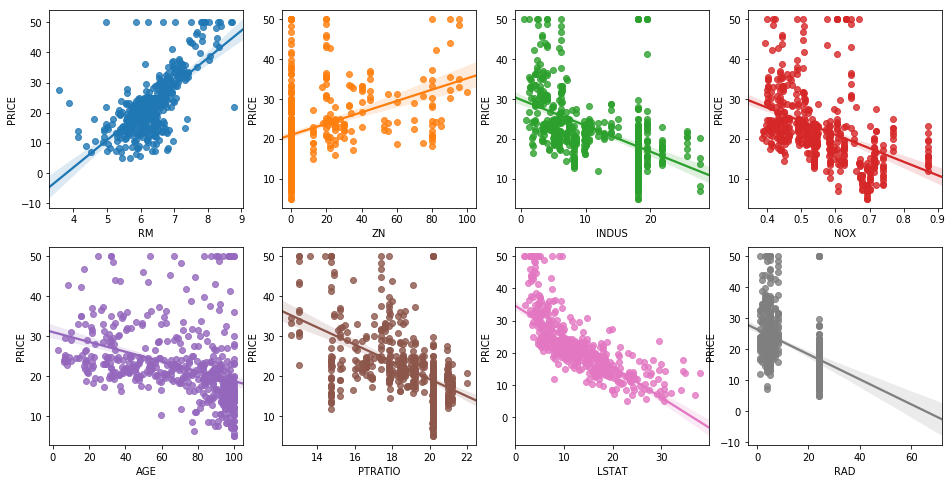

In [5]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])
    
# RM(방 개수), LSTAT(하위 계층의 비율)의 PRICE 영향도가 가장 크다

# sklearn의 LinearRegression() parameter
### fit_intercept : 절편 포함 여부 (default True)
### normalize : 정규화 (default False)
### coef_ : fit() 이후 회귀 계수를 배열로 저장, shape (Target 수, 피처 수)
### intercept_ : 절편 값

# 회귀 평가 지표
### MAE : Mean Absolute Error -> metrics.mean_absolute_error
### MSE : Mean Squared Error  -> metrics.mean_squared_error
### RMSE (Root MSE)
### R2 : 예측값 분산/실제값 분산 -> metrics.r2_score

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행. 
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('R squared : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.306 , RMSE : 4.160
R squared : 0.757


In [7]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.99559517216454
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [9]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성
coeff = pd.Series(data=np.round(lr.coef_, 2), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.35
CHAS        3.05
RAD         0.36
ZN          0.07
INDUS       0.03
B           0.01
AGE         0.01
TAX        -0.01
CRIM       -0.11
LSTAT      -0.57
PTRATIO    -0.92
DIS        -1.74
NOX       -19.80
dtype: float64

In [10]:
from sklearn.model_selection import cross_val_score

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함. 
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
# scoring에서의 MSE는 음수값으로, score값이 클수록 좋은 평가 결과로 평가 -> -1 곱해준다 (작을수록 좋은 값이기 위해)
avg_rmse = np.mean(rmse_scores)
rmse_scores  = np.sqrt(-1 * neg_mse_scores) 

print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.48 -26.1  -33.12 -80.83 -33.58]
 5 folds 의 개별 RMSE scores :  [3.53 5.11 5.75 8.99 5.8 ]
 5 folds 의 평균 RMSE : 5.836 
